In [1]:
from rescomp import ResComp, lorenz_equ
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from scipy import sparse


In [2]:
plt.rcParams["figure.figsize"] = [10,10]

### Functions

In [3]:
def plot_eigs(args,nbins=50, title="Eigenvalues", color="b", vert=False):
    """ Plots Eigenvalues in the complex plane and on the real axis
    """
    
    if len(args.shape) == 2:
        eigs = np.linalg.eigvals(args.toarray())
    else:
        eigs = args
        
    #eigs = .9*eigs/np.max(np.abs(eigs))
    x = eigs.real
    y = eigs.imag
    xbins = np.linspace(-20,20,nbins+2)
    ybins = np.linspace(-1,1,nbins+2)
    H, xedges, yedges = np.histogram2d(x, y, bins=(xbins, ybins))
    H = H.T
    H[H!=0] = np.log(H[H!=0])
    X, Y = np.meshgrid(xedges,yedges)
    
    # Eigs in 2D
    if color == "b":
        point_c = 'w'
        mesh_c = "Greys_r"
        real_c = "k"
    if color == "w":
        point_c = "k"
        mesh_c  = "Greys"
        real_c  = "gray"
        
    if not vert:
        f, (a0,a1) = plt.subplots(1,2, gridspec_kw={'width_ratios':[1,1]})
    if vert:
        f, (a0,a1) = plt.subplots(2,1, gridspec_kw={'height_ratios':[1,1]})
        
    a0.plot(x,y,',',c=point_c)
    a0.pcolormesh(X,Y,H,cmap=mesh_c)
    a0.set_ylabel(r'$\mathcal{I}m(\lambda)$')
    a0.set_xlabel(r'$\mathcal{R}e(\lambda)$')
    
    # Real Eigs
    real_mask = np.isclose(y,0,atol=1e-10)
    a1.hist(x[real_mask],bins=30,log=True, color=real_c)
    #a1.set_xlim(-1,1)
    #a1.set_ylim(1e-1,1e4)
    a1.set_ylabel("Log Frequency")
    a1.set_xlabel(r"Real Eigenvalues")
    
    f.suptitle(title)
    plt.show()

In [4]:
def watts():
    """ Watts-Strogatz small world model
    """
    n = np.random.randint(2000,3500)
    k = 5
    p = .05
    A = nx.adj_matrix(nx.watts_strogatz_graph(n,k,p)).T
    return sparse.dok_matrix(A)

def remove_edges(A,nedges):
    """ Randomly removes 'nedges' edges from a sparse matrix 'A'
    """
    A.todok()
    # Remove Edges
    keys = list(A.keys())
    remove_idx = np.random.choice(range(len(keys)),size=nedges, replace=False)
    remove = [keys[i] for i in remove_idx]
    for e in remove:
        A[e] = 0
    return A

In [5]:
def plot_coo_matrix(m):
    """ Plots nonzero entries of sparse array m as black pixels
        Credit to:
        https://stackoverflow.com/questions/22961541/
        python-matplotlib-plot-sparse-matrix-pattern
    """

    if not isinstance(m, sparse.coo_matrix):
        m = sparse.coo_matrix(m)
    fig = plt.figure()
    ax = fig.add_subplot(111, facecolor='white')
    ax.plot(m.col, m.row, marker=',', color='black', lw=0,linestyle="")
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

In [6]:
# Generate a watts-strogats network
Aorig = watts()

# Remove 75% of the edges
nnz = np.sum(Aorig != 0)
A = remove_edges(Aorig, int(nnz * .75))

# Reservoir params
params = {
    "res_sz": 2000,
    "ridge_alpha": 1e-05,
    "spect_rad": 0.9,
    "signal_dim": 3,
    "network": 'small world',
}
rc = ResComp(A, **params)

# Initial condition
X0 = 40*np.random.rand(3) - 20
tr_t, ts_t, u, = lorenz_equ(x0=X0)

# Fit reservoir
err = rc.fit(tr_t, u)
print(f"Error: {err}")

Error: 0.01916231587578765


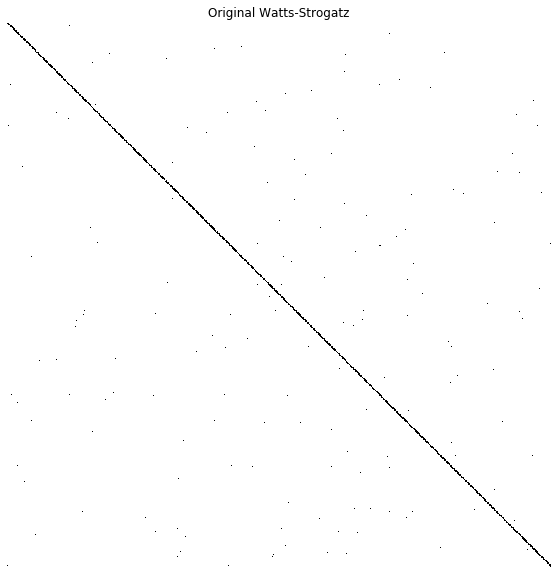

In [7]:
ax = plot_coo_matrix(Aorig)
ax.set_title("Original Watts-Strogatz")
plt.show(ax)

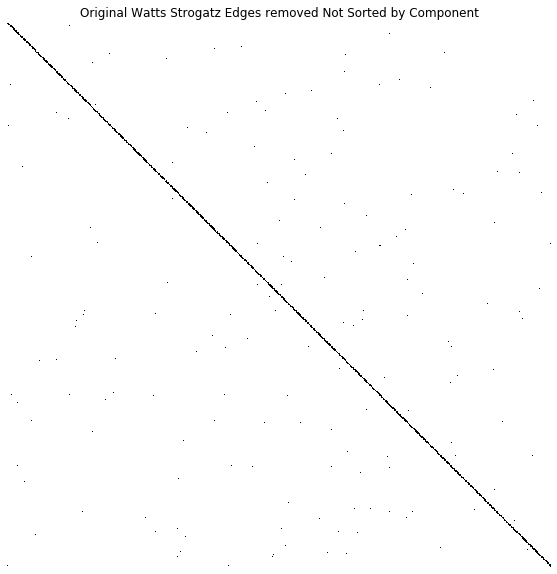

In [8]:
ax = plot_coo_matrix(A)
ax.set_title("Original Watts Strogatz Edges removed Not Sorted by Component")
plt.show(ax)

### Component Structure of $A$ (Watts strogatz 50% of edges removed)

In [9]:
### Identify Components
# Turn adj into a DiGraph
G = nx.DiGraph(A.toarray())
comps = [list(c) for c in nx.strongly_connected_components(G)]
 # Sort components by size, largest first
lens = [len(c) for c in comps]
mask = np.argsort(lens)
sort_comps = [c for i in mask[::-1] for c in comps[i]]
comp_mask = np.array(sort_comps)

Group nodes in the same component next to eachother in the adj matrix

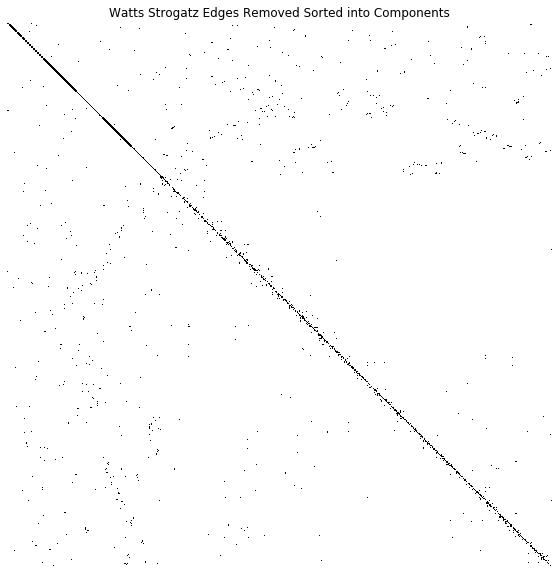

In [10]:
compA = A[comp_mask, :][:, comp_mask]
ax = plot_coo_matrix(compA)
ax.set_title("Watts Strogatz Edges Removed Sorted into Components")
plt.show(ax)

### Heat Map of $W =  \sigma W_{\text{in}}W_{\text{out}} $ Entries

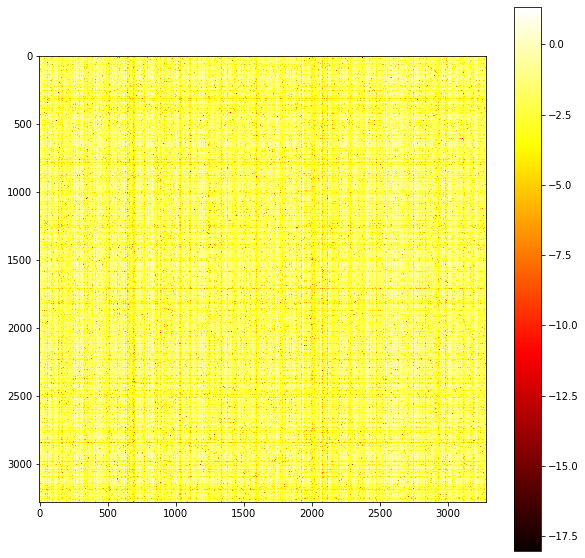

In [11]:
W = rc.sigma * rc.W_in.dot(rc.W_out)
plt.imshow(np.log(np.abs(W)), cmap='hot', interpolation='nearest')
plt.colorbar()


### Component Structure of $ W = \sigma W_{\text{in}}W_{\text{out}} $
Group nodes in this matrix together by which component they belonged to in the original adjacency matrix. Is there any connection between edges in $W$ and edges in $A$?

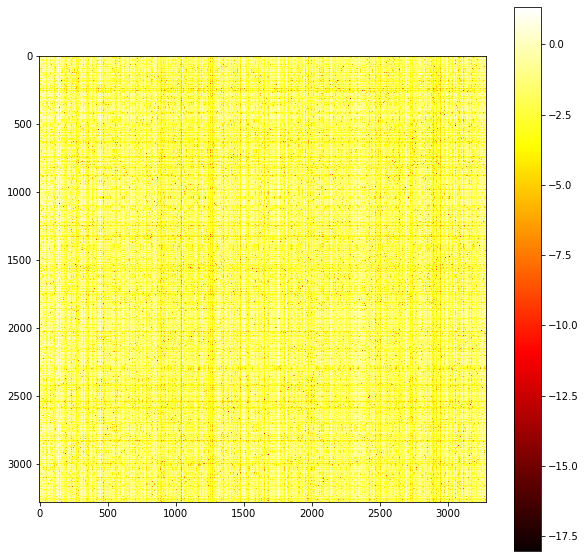

In [12]:
compW = W[comp_mask, :][:, comp_mask]
plt.imshow(np.log(np.abs(compW)), cmap='hot', interpolation='nearest')
plt.colorbar()

### Analysis of Some Aspects of $ \sigma W_{\text{in}}W_{\text{out}} $

In [13]:
abW = np.abs(W)
mu = np.mean(abW)
print(f"Mean of |W|: {mu}")
print(f"Median of |W|: {np.median(abW)}")
print(f"Max of |W|: {np.max(abW)}")
print(f"Percent of entries bigger than mean: {np.sum(abW > mu)/abW.shape[0]**2}")

Mean of |W|: 0.2710014727478619
Median of |W|: 0.1840520272214547
Max of |W|: 3.74404092251653
Percent of entries bigger than mean: 0.3604834361986913


### Set entries smaller than the mean to zero

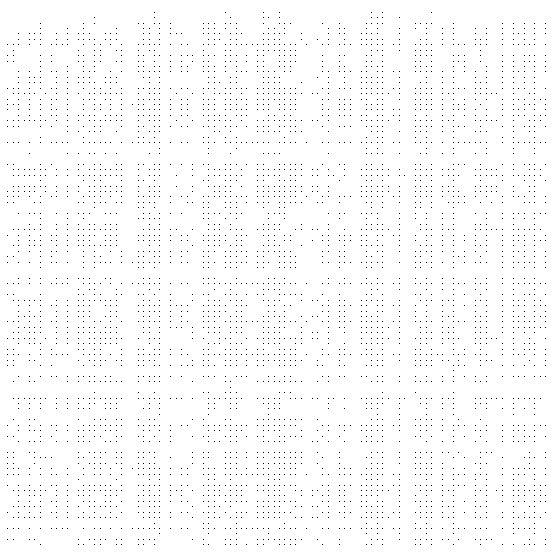

In [14]:
maskedW = np.copy(W)
maskedW[abW < mu] = 0.0
maskedW = sparse.lil_matrix(maskedW)
ax = plot_coo_matrix(maskedW[comp_mask[:100],:][:, comp_mask[:100]])

### Eigenvalues

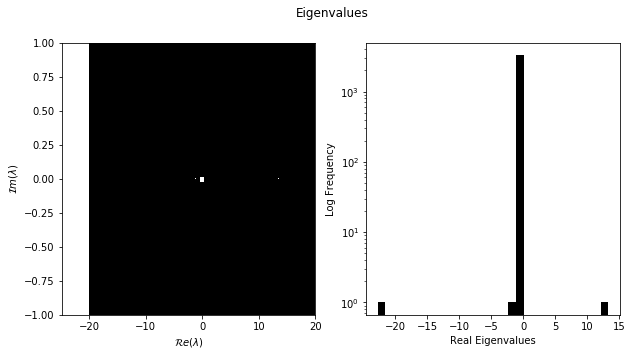

In [15]:
plt.rcParams["figure.figsize"] = [10,5]
plot_eigs(sparse.lil_matrix(W))